In [1]:
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
pd.set_option('display.max_rows',1000)

In [2]:
try:
    conn = sqlite3.connect("../data/cruise_pre.db")
    conn2 = sqlite3.connect("../data/cruise_post.db")
except Exception as e:
    print(e)

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

cursor = conn2.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

df = pd.read_sql_query('SELECT * FROM cruise_pre', conn)
df2 = pd.read_sql_query('SELECT * FROM cruise_post', conn2)
conn.close()
conn2.close()

Table Name : [('cruise_pre',)]
Table Name : [('cruise_post',)]


In [3]:
#
# check what columns there are and the column name spellings
#

for c in df.columns:
    print(c,":",df[c].dtype)
print(df.shape)

print("\n")
for c in df2.columns:
    print(c, ":", df2[c].dtype)

print(df2.shape)

index : int64
Gender : object
Date of Birth : object
Source of Traffic : object
Onboard Wifi Service : object
Embarkation/Disembarkation time convenient : float64
Ease of Online booking : float64
Gate location : float64
Logging : object
Onboard Dining Service : object
Online Check-in : float64
Cabin Comfort : float64
Onboard Entertainment : object
Cabin service : float64
Baggage handling : float64
Port Check-in Service : float64
Onboard Service : float64
Cleanliness : float64
Ext_Intcode : object
(133746, 19)


index : int64
Cruise Name : object
Ticket Type : object
Cruise Distance : object
Ext_Intcode : object
WiFi : float64
Dining : int64
Entertainment : float64
(133746, 8)


## Remove unsuitable data - Cruise_Pre

1. remove columns that do not seem to affect outcome of ticket type.
2. They are 'Source of Traffic', 'Embarkation/Disembarkation time convenient',
            'Ease of Online booking', 'Gate location', 'Logging'
3. Remove rows with duplicated ExtIntcode. Remove the duplicated one that has more null values



In [4]:
#
# drop columns that are not suitable as variables
#
drop_cols = ['Source of Traffic', 'Embarkation/Disembarkation time convenient',
            'Ease of Online booking', 'Gate location', 'Logging']
df.drop(drop_cols ,axis=1, inplace=True)

In [9]:
#
# check for duplicates in Ext_Intcode
#
df[df['Ext_Intcode'].duplicated()].shape

(3896, 14)

In [5]:
#
# check for number of null values in each row
# remove duplicated ext_intcode with more null values
#
df['num_na']=0
df['num_na'] = df.apply(lambda x: x.isna().sum(), axis=1)
#
#
df_dup = df[df['Ext_Intcode'].duplicated()]
todrop = []
for ind, r2 in df_dup.iterrows():
    max_na = df[df['Ext_Intcode']==r2['Ext_Intcode']]['num_na'].max()
    dfx = df[(df['Ext_Intcode']==r2['Ext_Intcode']) & (df['num_na']==max_na)]
    if len(dfx) > 1:
        todrop.append(dfx.index[0])
    else:
        todrop.append(dfx.index[0])
        #print(dfx.index[0])
df.drop(todrop, inplace=True)

df[df['Ext_Intcode'].duplicated()].shape

(0, 15)

In [6]:
df.shape

(129850, 15)

### 1. NULL VALUES - Cruise_Pre

The following cells is the check for null values. 
1. The rows that have null values in gender or date of birth columns are removed
2. Categorical columns ['Onboard Wifi Service','Onboard Dining Service', 'Online Check-in', 
            'Cabin Comfort','Onboard Entertainment', 'Cabin service', 'Baggage handling',
            'Port Check-in Service', 'Onboard Service', 'Cleanliness'] that have null or invalid values (0) are treated as 'N_A'. In a survey, when a person does not answer it could most likely mean they have no opinion on that or its not applicable to them
            


In [7]:
# check the number of null values in each column

for c in df.columns:
    print(c,":", df[df[c].isna()].shape)

index : (0, 15)
Gender : (13069, 15)
Date of Birth : (14285, 15)
Onboard Wifi Service : (18924, 15)
Onboard Dining Service : (16341, 15)
Online Check-in : (15216, 15)
Cabin Comfort : (16356, 15)
Onboard Entertainment : (15447, 15)
Cabin service : (13454, 15)
Baggage handling : (16397, 15)
Port Check-in Service : (13946, 15)
Onboard Service : (17751, 15)
Cleanliness : (14506, 15)
Ext_Intcode : (0, 15)
num_na : (0, 15)


In [8]:
#
#  Gender null values - remove rows
#
print("GENDER")
print(df['Gender'].unique())
print(df.groupby(['Gender'])['Gender'].count())
print(df[df['Gender'].isna()].shape)
#
# since there is no good way to fillna for gender , will drop the rows with null gender values
#
df = df[df['Gender'].isna()==False].copy()
print(df[df['Gender'].isna()].shape)
print(df.shape, "\n")

#
# since there is no good way to fillna for date of birth , will drop the rows with null date of birth values
#
print(df[df['Date of Birth'].isna()].shape)
df = df[df['Date of Birth'].isna()==False].copy()
print(df[df['Date of Birth'].isna()].shape)
print(df.shape)


GENDER
[None 'Female' 'Male']
Gender
Female    59175
Male      57606
Name: Gender, dtype: int64
(13069, 15)
(0, 15)
(116781, 15) 

(12886, 15)
(0, 15)
(103895, 15)


In [9]:
#
# review the categories in the categorical columns
#
cat_cols = ['Onboard Wifi Service','Onboard Dining Service', 'Online Check-in', 
            'Cabin Comfort','Onboard Entertainment', 'Cabin service', 'Baggage handling',
            'Port Check-in Service', 'Onboard Service', 'Cleanliness']

for c in cat_cols:
    print(c, ":", df[c].unique())

Onboard Wifi Service : [None 'Very important' 'Somewhat important' 'Extremely important'
 'Not at all important' 'A little important']
Onboard Dining Service : [None 'Somewhat important' 'Not at all important' 'Very important'
 'A little important' 'Extremely important']
Online Check-in : [nan  4.  2.  1.  0.  5.  3.]
Cabin Comfort : [ 5.  4.  1.  2.  3. nan  0.]
Onboard Entertainment : ['Extremely important' None 'Not at all important' 'Very important'
 'A little important' 'Somewhat important']
Cabin service : [ 2. nan  3.  5.  4.  1.  0.]
Baggage handling : [ 1. nan  3.  4.  5.  2.]
Port Check-in Service : [ 2.  3.  5.  4.  1. nan]
Onboard Service : [ 3.  2.  4. nan  5.  1.  0.]
Cleanliness : [nan  4.  1.  2.  3.  5.  0.]


In [10]:
#
# Consider invalid values (ie 0) as null values .. null values are 
# probably not answered in the survey to indicate that the customer has no opinion about this category
# create another value 0 to indicate 'N_A'
#
# 
cat_col_words = ['Onboard Wifi Service', 'Onboard Dining Service', 'Onboard Entertainment']
cat_col_num = ['Online Check-in', 'Cabin Comfort', 'Cabin service', 'Baggage handling',
                'Port Check-in Service', 'Onboard Service', 'Cleanliness']
for c in cat_col_words:
    df[c].fillna('N_A',inplace=True)

for c in cat_col_num:
    df[c].fillna(0,inplace=True)

#
# treat these as na. First fillna to 0 then replace according to the ratio of non-zero ones
#

#df.fillna(0, inplace=True)

In [11]:
#
# check for null or 0 values... should not have any null or 0
# check also for any invalid values
#


for c in cat_cols:
    print(c,":", df[df[c].isna()].shape, df[c].unique(), "\n")

Onboard Wifi Service : (0, 15) ['N_A' 'Very important' 'Somewhat important' 'Extremely important'
 'Not at all important' 'A little important'] 

Onboard Dining Service : (0, 15) ['N_A' 'Somewhat important' 'Not at all important' 'Very important'
 'A little important' 'Extremely important'] 

Online Check-in : (0, 15) [0. 4. 2. 1. 5. 3.] 

Cabin Comfort : (0, 15) [5. 4. 1. 2. 3. 0.] 

Onboard Entertainment : (0, 15) ['Extremely important' 'N_A' 'Not at all important' 'Very important'
 'A little important' 'Somewhat important'] 

Cabin service : (0, 15) [2. 0. 3. 5. 4. 1.] 

Baggage handling : (0, 15) [1. 0. 3. 4. 5. 2.] 

Port Check-in Service : (0, 15) [2. 3. 5. 4. 1. 0.] 

Onboard Service : (0, 15) [3. 2. 4. 0. 5. 1.] 

Cleanliness : (0, 15) [0. 4. 1. 2. 3. 5.] 



## Remove duplicated data - Cruise_Post

1. Remove rows with duplicated Ext_Intcode. Remove the duplicated one that has more null values


In [12]:
#
# check for number of null values in each row
# remove duplicated ext_intcode with more null values
#
df2['num_na']=0
df2['num_na'] = df2.apply(lambda x: x.isna().sum(), axis=1)
#
#
df_dup2 = df2[df2['Ext_Intcode'].duplicated()]
todrop = []
for ind, r2 in df_dup2.iterrows():
    max_na = df2[df2['Ext_Intcode']==r2['Ext_Intcode']]['num_na'].max()
    dfx = df2[(df2['Ext_Intcode']==r2['Ext_Intcode']) & (df2['num_na']==max_na)]
    if len(dfx) > 1:
        todrop.append(dfx.index[0])
    else:
        todrop.append(dfx.index[0])
        #print(dfx.index[0])
df2.drop(todrop, inplace=True)

df2[df2['Ext_Intcode'].duplicated()].shape

(0, 9)

## Null & Invalid Values - Cruise_post
1. Cruise Name mis-spellings or short forms . After cleaning, only 2 cruise names - Blastoise and Lapras. Fill the null values according to ratios of these 2 names
2. Ticket Type is our target column. Remove rows with null Ticket Type
3. Fix Cruise Distance different units - change Cruise Distance to numeric and convert all the Miles ones to KM. Those with negative values are converted to positive. Remove rows with null Cruise Distance
4. Null values in WiFi and Entertainment filled with 2 to indicate N_A



In [13]:
# determine the number of null values in each column

for c in df2.columns:
    if c == 'index' or c=='Ext_Intcode' or c=='num_na':
        continue
    print(c,":", df2[df2[c].isna()].shape, df2[c].unique(), "\n")

Cruise Name : (15446, 9) ['Blastoise' 'IAPRAS' 'Lapras' None 'blast' 'lap' 'blastoise' 'blast0ise'
 'lapras'] 

Ticket Type : (18951, 9) [None 'Deluxe' 'Standard' 'Luxury'] 

Cruise Distance : (14077, 9) ['3567 KM' '672 KM' '1167 KM' ... '3292 Miles' '-751 Miles' '2656 Miles'] 

WiFi : (67711, 9) [ 1. nan  0.] 

Dining : (0, 9) [1 0] 

Entertainment : (58301, 9) [ 1.  0. nan] 



In [14]:
#
# remove rows with null Ticket Type as that is the target variable
#
df2 = df2[df2['Ticket Type'].isna()==False].copy()

In [16]:
# seems that blast0ise = blastoise = Blastoise & IAPRAS = Lapras = lapras. Correct and standardize this

df2['Cruise Name'] = df2.apply(lambda x: 'Blastoise' if x['Cruise Name']=='blastoise' else x['Cruise Name'], axis=1)
df2['Cruise Name'] = df2.apply(lambda x: 'Blastoise' if x['Cruise Name']=='blast0ise' else x['Cruise Name'], axis=1)

df2['Cruise Name'] = df2.apply(lambda x: 'Lapras' if x['Cruise Name']=='IAPRAS' else x['Cruise Name'], axis=1)
df2['Cruise Name'] = df2.apply(lambda x: 'Lapras' if x['Cruise Name']=='lapras' else x['Cruise Name'], axis=1)


<Axes: title={'center': 'Cruise Name'}>

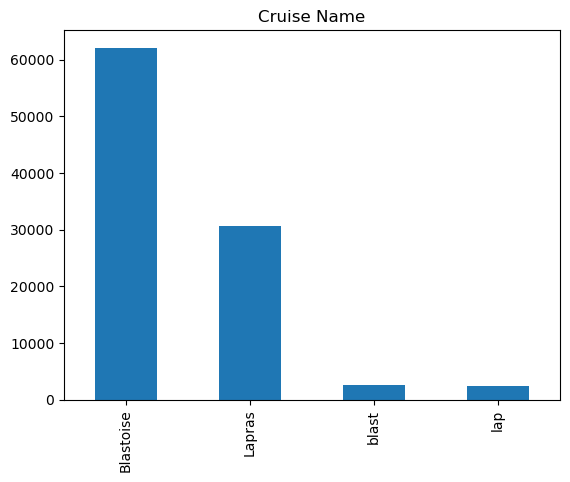

In [17]:
df2['Cruise Name'].value_counts().plot(kind='bar', title='Cruise Name')

In [18]:
#
# looking at the above plot, it is also possible for blast to the Blastoise & lap to be Lapras. 
# set lap to Lapras & blast to Blastoise
#
df2['Cruise Name'] = df2.apply(lambda x: 'Blastoise' if x['Cruise Name']=='blast' else x['Cruise Name'], axis=1)

df2['Cruise Name'] = df2.apply(lambda x: 'Lapras' if x['Cruise Name']=='lap' else x['Cruise Name'], axis=1)

64623
33084
(0, 9)


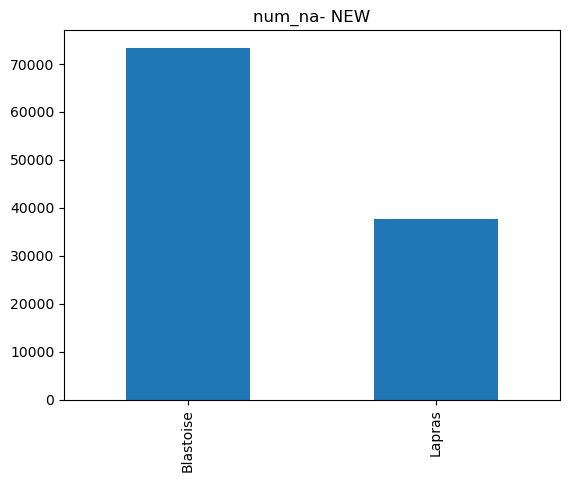

In [19]:
#
# For Cruise Name fillna based on the ratio of the 2 cruise names
#

nullvalues = df2[df2['Cruise Name'].isna()].shape[0] #df[df[c].isna()].shape[0]
#
# check the ratio of response and fillna based on this ratio
#
valcnt = df2[df2['Cruise Name'].isna()==False]['Cruise Name'].value_counts().to_dict()
nonnull_values = df2[df2['Cruise Name'].isna()==False].shape[0]
valnum = {}
newvalue=0
for k in valcnt:
    print(valcnt[k])
    valratio = valcnt[k]/nonnull_values
    newvalue = newvalue + valratio*nullvalues
    valnum = {**valnum, **{k:newvalue}}
    
cnt = 0
keys_ = list(valnum.keys())
for ind, r in df2[df2['Cruise Name'].isna()].iterrows():
    if cnt < valnum[keys_[0]]+1:
        df2.loc[ind, 'Cruise Name']= keys_[0]
    else:
        df2.loc[ind, 'Cruise Name']= keys_[1]
    cnt+=1

#
# after filling null (0) values plot to see that ratio about the same
#
df2['Cruise Name'].value_counts().plot(kind='bar', title=c+"- NEW")
print(df2[df2['Cruise Name'].isna()].shape)
plt.show()

In [ ]:
#
# Cruise Distance
#
df2['Cruise Distance'].sample(50)

In [20]:
#
# seems like Cruise Distance have different units - change them to the same units &
# drop rows with null distances
#

df2['Distance_type'] = df2.apply(lambda x: x['Cruise Distance'].split(" ")[-1] 
                                 if x['Cruise Distance']!=None else x['Cruise Distance'], axis=1)

df2['Distance'] = df2.apply(lambda x: int(x['Cruise Distance'].split(" ")[0]) if x['Cruise Distance']!=None 
                            else x['Cruise Distance'], axis=1)


#
# as distance is an important factor to ticket type, drop the ones with null distance values
#
df2 = df2[df2['Distance'].isna()==False].copy()

In [21]:
print(df2['Distance_type'].unique())
print(df2[df2['Distance']<=0].shape)

['KM' 'Miles']
(7365, 11)


In [22]:
#
# change negative distances to positive, convert distance in miles to distance in km
#
#
df2['Distance'] = df2.apply(lambda x: x['Distance']*-1 if x['Distance']<0 else x['Distance'], axis=1)
df2['Distance'] = df2.apply(lambda x: int(x['Distance']*1.60934) if x['Distance_type']=='Miles' 
                            else x['Distance'], axis=1)


min       31.000000
mean    1266.940228
max     7987.000000
Name: Distance, dtype: float64


<Axes: ylabel='Frequency'>

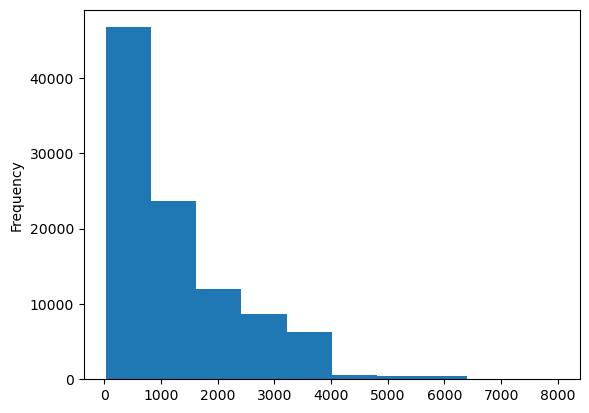

In [23]:


print(df2['Distance'].agg(['min', 'mean', 'max']))

df2['Distance'].plot(kind='hist')

In [24]:
#
# don't need Distance Type and Cruise Distance for the ML pipeline, drop them
#

df2.drop(['Distance_type', 'Cruise Distance'], axis=1, inplace=True)

In [25]:
#
# for wifi and entertainment, replace null values with category number 2 to indicate NA
#
df2['Entertainment'].fillna(2, inplace=True)
df2['WiFi'].fillna(2, inplace=True)

In [26]:
print(df2[df2['WiFi'].isna()].shape)
print(df2[df2['Entertainment'].isna()].shape)

(0, 9)
(0, 9)


In [27]:
for c in df2.columns:
    print(df2[df2[c].isna()].shape)

(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)


### Merge the 2 dataframes

1. inner join to ensure no null values


In [28]:
#
# now we can merge cleaned df & df2. Do an inner merge so that we get a set of data with no nulls
#
df_merge = df.merge(df2, how='inner', on='Ext_Intcode')

In [31]:
print(df_merge.shape)
print(df_merge.columns)

(79063, 23)
Index(['index_x', 'Gender', 'Date of Birth', 'Onboard Wifi Service',
       'Onboard Dining Service', 'Online Check-in', 'Cabin Comfort',
       'Onboard Entertainment', 'Cabin service', 'Baggage handling',
       'Port Check-in Service', 'Onboard Service', 'Cleanliness',
       'Ext_Intcode', 'num_na_x', 'index_y', 'Cruise Name', 'Ticket Type',
       'WiFi', 'Dining', 'Entertainment', 'num_na_y', 'Distance'],
      dtype='object')


In [32]:
# drop some columns - num_na_x, num_na_y, index_y and rename index_x to index
#
df_merge.drop(['num_na_x', 'num_na_y', 'index_y'], axis=1, inplace=True)
df_merge.rename({'index_x':'index'}, inplace=True, axis=1)

<Axes: >

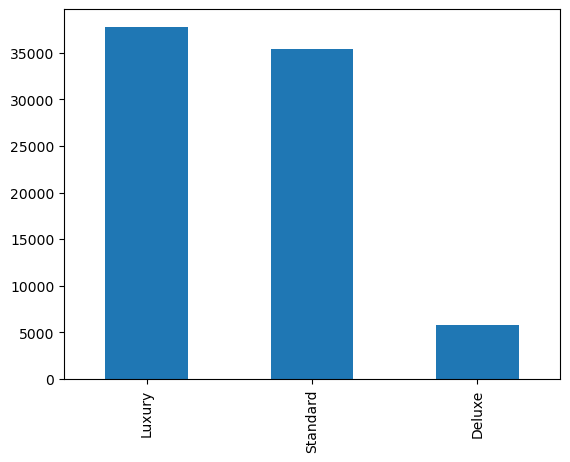

In [30]:
# 
# the data is skewed towards 0 & 2.
#
df_merge['Ticket Type'].value_counts().plot(kind='bar')

### Feature Engineering
1. Use Date of Birth, extract the year of birth and determine age (drop rows with ages > 102)
2. Encode categorical columns with numeric categories
3. normalize distance
4. Bin age into 5 bins (<25, <35,<45 <55, >55)

In [34]:
#
# some date of births looked invalid (e.g. 18xx)
# extract year from DOB first then determine current age
#

df_merge[df_merge['Date of Birth'].str.contains("/")==True].sample(100)
df_merge['YOB'] = df_merge.apply(lambda x: int(x['Date of Birth'].split("/")[-1]) if "/" in x['Date of Birth']
                                 else int(x['Date of Birth'].split("-")[0]), axis=1)
df_merge['age'] = df_merge.apply(lambda x: 2023-x['YOB'], axis=1)

In [35]:
#
# remove rows with age that are more than 100
#
df_merge = df_merge[df_merge['age']<100].copy()

In [36]:
#
# drop DOB and YOB columns - not used in ML model training
#
df_merge.drop(['Date of Birth', 'YOB'], axis=1, inplace=True)

max    85
min     7
Name: age, dtype: int64


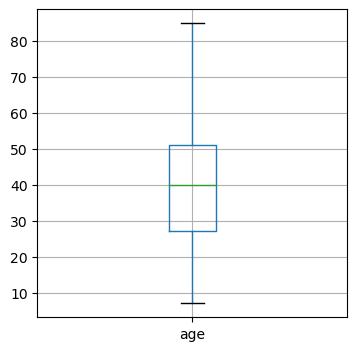

<Axes: ylabel='Frequency'>

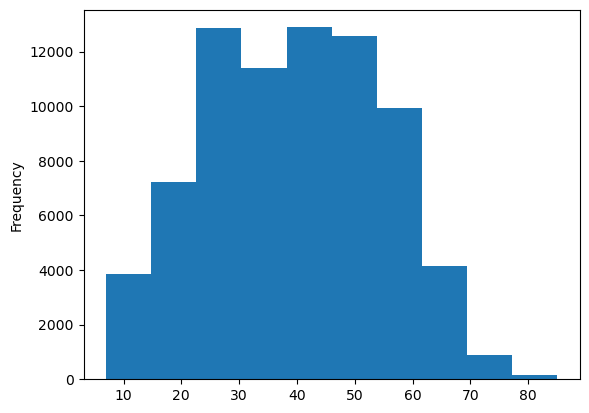

In [48]:
#
# print stats for age
# plot age to see distribution then bin it into categories
#
print(df_merge['age'].agg(['max', 'min']))

df_merge.boxplot(column=['age'], figsize=(4,4))
plt.show()

df_merge['age'].plot(kind='hist')

In [44]:
#
# bin ages into 5 bins 0 - <25, 1 - <35, 2 - <45, 3 - <55, 4 - >55
#
def categorize_age(r):
    if r['age'] < 25:
        return 0
    elif r['age'] < 35:
        return 1
    elif r['age'] < 45:
        return 2
    elif r['age'] < 55:
        return 3
    else:
        return 4

df_merge['age_grp'] = df_merge.apply(categorize_age, axis=1)

In [47]:
df_merge.sample(5)

,Online Check-in,Cabin Comfort,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,WiFi,Dining,Entertainment,Distance,age,Wifi_pre,Dining_pre,Entertainment_pre,gender_cat,Cruise_num,ticket_cat,age_grp
43351,4,0,0,1,1,3,3,2,1,2,547.0,26,4,3,3,1,0,0,1
70121,4,3,1,3,2,0,3,2,1,2,395.0,47,2,3,3,0,1,0,3
35508,4,4,4,4,3,4,4,0,0,0,735.0,51,0,3,4,1,0,2,3
10081,1,1,1,3,3,0,1,2,1,2,373.0,24,0,1,1,1,0,0,0
76422,3,5,1,3,1,3,0,2,0,2,247.0,26,3,5,5,1,1,0,1


min         31.000000
max       7987.000000
mean      1263.071287
median     868.000000
Name: Distance, dtype: float64


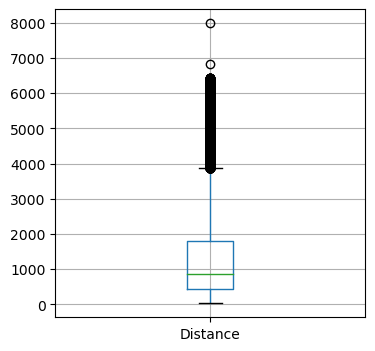

<Axes: ylabel='Frequency'>

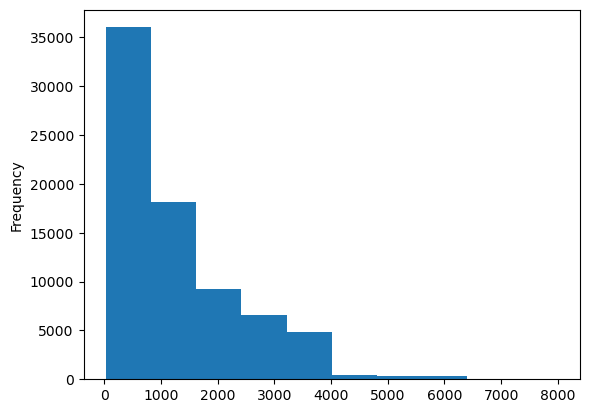

In [50]:
dist_stats = df_merge['Distance'].agg(['min','max', 'mean', 'median'])
print(dist_stats)
df_merge.boxplot(column=['Distance'], figsize=(4,4))
plt.show()
df_merge['Distance'].plot(kind='hist')


In [51]:
#
# seems like a lot of outliers. Normalize this column
df_merge['distance_scaled'] = df_merge.apply(lambda x: (x['Distance']-dist_stats['min'])/(dist_stats['max']-dist_stats['min']), axis=1)

In [37]:
#
# non-numeric categorical columns to be reclassified as numeric categorical columns
# 0 - N_A, 1 - Not at all important, 2 - A little important, 3 - Somewhat important, 4 - Very important,
# 5 - Extremely important
#

cat_col_words = ['Onboard Wifi Service', 'Onboard Dining Service', 'Onboard Entertainment']

for indx, rowx in df_merge.iterrows():
    for c in cat_col_words:
        value = rowx[c]
        if value=='N_A':
            catvalue = 0
        elif value=='Not at all important':
            catvalue = 1
        elif value=='A little important':
            catvalue = 2
        elif value=='Somewhat important':
            catvalue = 3
        elif value=='Very important':
            catvalue = 4
        elif value=='Extremely important':
            catvalue = 5
        
        df_merge.loc[indx, c+'_num'] = catvalue

# gender 0 - Male, 1 - Female
df_merge['gender_cat'] = df_merge.apply(lambda x: 0 if x['Gender']=='Male' else 1, axis=1)

#Cruise Name 0 - Blastoise, 1 - Lapras 

df_merge['Cruise_num'] = df_merge.apply(lambda x: 0 if x['Cruise Name']=='Blastoise' else 1, axis=1)

#Ticket type 0 - Standard, 1 - Deluxe, 2 - Luxury

def ticket_num(row):
    if row['Ticket Type'] == 'Standard':
        return 0
    elif row['Ticket Type'] == 'Deluxe':
        return 1
    elif row['Ticket Type']=='Luxury':
        return 2

df_merge['ticket_cat'] = df_merge.apply(ticket_num, axis=1)  

In [38]:
rnm_cols = {'Onboard Wifi Service_num':'Wifi_pre', 'Onboard Entertainment_num':'Entertainment_pre', 
            'Onboard Dining Service_num':'Dining_pre'}
df_merge.rename(rnm_cols, inplace=True, axis=1)

In [39]:
# change categorical columns to int
#
columns_int = ['Online Check-in', 'Cabin Comfort', 'Cabin service', 'Baggage handling',
              'Port Check-in Service', 'Onboard Service', 'Cleanliness', 'WiFi','Dining', 'Entertainment',
              'Wifi_pre', 'Entertainment_pre', 'Dining_pre', 'gender_cat', 'Cruise_num', 'ticket_cat' ]
import numpy as np
for c in columns_int:
    df_merge[c] = df_merge[c].astype(np.int8)
df_merge

,index,Gender,Onboard Wifi Service,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,...,Dining,Entertainment,Distance,age,Wifi_pre,Dining_pre,Entertainment_pre,gender_cat,Cruise_num,ticket_cat
0,2,Female,N_A,N_A,0,5,Extremely important,2,1,2,...,0,0,1167.0,25,0,0,5,1,1,1
1,3,Female,Very important,Somewhat important,4,4,N_A,0,0,3,...,0,1,280.0,53,4,3,0,1,1,1
2,5,Male,Somewhat important,Not at all important,2,1,Not at all important,3,3,5,...,1,2,1842.0,63,3,1,1,0,1,0
3,6,Male,Somewhat important,Very important,0,4,Very important,0,4,3,...,1,2,607.0,37,3,4,4,0,1,0
4,10,Male,A little important,Extremely important,2,3,Extremely important,3,1,1,...,0,2,594.0,15,2,5,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79057,133733,Male,Very important,Not at all important,4,1,Not at all important,5,4,4,...,0,0,936.0,65,4,1,1,0,1,1
79058,133734,Female,A little important,Not at all important,4,4,N_A,2,2,4,...,1,1,1900.0,44,2,1,0,1,1,2
79060,133739,Female,N_A,N_A,4,5,Very important,4,4,3,...,0,2,2717.0,61,0,0,4,1,0,0
79061,133743,Male,Extremely important,Extremely important,5,5,Extremely important,4,5,4,...,0,1,1947.0,11,5,5,5,0,0,2


In [40]:
for c in df_merge.columns:
    print(c,":",df_merge[df_merge[c].isna()].shape)

index : (0, 26)
Gender : (0, 26)
Onboard Wifi Service : (0, 26)
Onboard Dining Service : (0, 26)
Online Check-in : (0, 26)
Cabin Comfort : (0, 26)
Onboard Entertainment : (0, 26)
Cabin service : (0, 26)
Baggage handling : (0, 26)
Port Check-in Service : (0, 26)
Onboard Service : (0, 26)
Cleanliness : (0, 26)
Ext_Intcode : (0, 26)
Cruise Name : (0, 26)
Ticket Type : (0, 26)
WiFi : (0, 26)
Dining : (0, 26)
Entertainment : (0, 26)
Distance : (0, 26)
age : (0, 26)
Wifi_pre : (0, 26)
Dining_pre : (0, 26)
Entertainment_pre : (0, 26)
gender_cat : (0, 26)
Cruise_num : (0, 26)
ticket_cat : (0, 26)


In [ ]:
#
# drop columns that are not needed
#
df_merge.drop(['Gender','Onboard Wifi Service', 'Onboard Dining Service', 
               'Onboard Entertainment', 'Ticket Type', 'Cruise Name', 'Ext_Intcode', 'index', 'distance', 'age'], axis=1, inplace=True)

In [54]:
df_merge.sample(50)

,Online Check-in,Cabin Comfort,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,WiFi,Dining,Entertainment,Wifi_pre,Dining_pre,Entertainment_pre,gender_cat,Cruise_num,ticket_cat,age_grp,distance_scaled
22778,4,5,3,3,4,0,4,2,0,2,0,2,3,1,0,0,4,0.135244
57302,5,5,4,4,4,4,5,1,1,0,5,4,4,1,1,2,3,0.275138
33763,2,5,3,4,0,4,0,1,0,1,2,5,5,1,0,2,2,0.030040
71190,3,4,3,3,4,3,1,1,0,0,3,2,3,0,1,2,4,0.374309
58914,5,0,4,4,5,4,5,1,1,0,0,4,4,1,0,2,3,0.349925
58753,4,4,1,1,3,1,3,1,1,0,1,4,1,0,0,2,2,0.545877
61264,0,4,3,4,3,2,4,1,1,0,4,0,4,0,1,2,1,0.348165
39355,5,3,4,4,4,4,2,2,1,0,4,2,4,1,0,1,4,0.096782
42749,1,0,4,0,5,5,5,1,0,1,1,5,0,1,0,2,2,0.269356
18593,5,5,5,5,5,5,3,1,1,0,2,0,5,0,0,2,3,0.187531


In [53]:
#
# drop age and distance
#
df_merge.drop(['age', 'Distance'], axis=1, inplace=True)

In [42]:
df_merge.columns

Index(['Online Check-in', 'Cabin Comfort', 'Cabin service', 'Baggage handling',
       'Port Check-in Service', 'Onboard Service', 'Cleanliness', 'WiFi',
       'Dining', 'Entertainment', 'Wifi_pre', 'Dining_pre',
       'Entertainment_pre', 'gender_cat', 'Cruise_num', 'ticket_cat',
       'distance_scaled', 'age_grp'],
      dtype='object')